<a href="https://colab.research.google.com/github/Resia05/portfolio/blob/main/NLP_Classification_%D1%83%D0%BA%D1%80%D0%B0%D1%97%D0%BD%D1%81%D1%8C%D0%BA%D0%BE%D1%8E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.







# Завантаження та ознайомлення з набором даних

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = '/content/drive/MyDrive/Colab Notebooks/train.csv.zip'
raw_df = pd.read_csv(data)

In [ ]:
pd.set_option('display.max_colwidth', None)
raw_df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


In [ ]:
raw_df.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [ ]:
raw_df.shape

(27481, 4)

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
raw_df.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [ ]:
df = raw_df.dropna()

In [ ]:
df.shape

(27480, 4)

# Exploratory Data Analysis

In [ ]:
# Отримуємо нормалізований розподіл sentiment
class_counts_ = df.sentiment.value_counts(normalize=True)
class_counts = class_counts_.reset_index()

# Перейменовуємо стовпці для зручності
class_counts.columns = ['sentiment', 'proportion']

# Стилізуємо таблицю
class_counts.style.background_gradient(cmap='Blues')

,sentiment,proportion
0,neutral,0.404549
1,positive,0.312300
2,negative,0.283151


In [ ]:
import plotly.express as px

# Створюємо графік з індексами як класами
fig = px.bar(x=class_counts_.index,
             y=class_counts_.values,
             labels={'x': 'Клас', 'y': 'Пропорція'},
             title='Розподіл класів sentiment',
             color=class_counts_.index,
             color_discrete_sequence=px.colors.sequential.Magma)  # Використовуємо дискретну синю гаму

fig.show()

In [ ]:
# Додаємо нову колонку з довжиною тексту в символах
df.loc[:, 'text_length'] = df['text'].apply(len)

# Візуалізація розподілу довжин текстів
fig = px.histogram(df,
                   x='text_length',
                   nbins=50,
                   marginal="box",  # Додає діаграму розмаху
                   title='Розподіл довжин текстів в символах',
                   labels={'text_length': 'Довжина тексту (символи)', 'count': 'Кількість постів'},
                   color_discrete_sequence=['blue'])

fig.show()

<ipython-input-63-4138801c595f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Описова статистика довжин текстів
df['text_length'].describe()

,text_length
count,27480.000000
mean,68.330022
std,35.603870
min,3.000000
25%,39.000000
50%,64.000000
75%,97.000000
max,141.000000


Довжина тексту розподілена добре, практично немає викидів, за виключенням min / max довжини.

# Попередня обробка текстових даних та векторизація з bag of words, 3 методами


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')

english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer(language='english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Метод 1: Простий процес токенізації без очищення тексту, що може знижувати якість векторизації.


In [ ]:
# Функція для токенізації та стемінгу тексту аби замінити стандартну в CountVectorizer
def tokenize(text):
    return [stemmer.stem(word) for word in word_tokenize(text)]

# Ініціалізація векторизатора
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=english_stopwords,
                             max_features=1500)

# Отримання векторів
bow_features = vectorizer.fit_transform(df['text'])

# Перегляд розмірності матриці
print('Розмірність матриці BoW:', bow_features.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.



Розмірність матриці BoW: (27480, 1500)


Метод 2: Більш складна попередня обробка тексту з видаленням спеціальних символів, цифр і стоп-слів, що покращує якість векторизації.

In [ ]:
# Функція для токенізації та стемінгу тексту
def tokenize(text):
    # Приведення тексту до нижнього регістру
    text = text.lower()
    # Видалення спеціальних символів та чисел
    text = re.sub(r'[^a-z\s]', '', text)
    # Токенізація
    words = word_tokenize(text)
    # Видалення стоп-слів та стемінг
    tokens = [stemmer.stem(word) for word in words if word not in english_stopwords]
    return tokens

# Ініціалізація векторизатора
vectorizer = CountVectorizer(tokenizer=tokenize,
                             max_features=1500)

# Отримання векторів
bow_features = vectorizer.fit_transform(df['text'])

# Перегляд розмірності матриці
print('Розмірність матриці BoW:', bow_features.shape)


Розмірність матриці BoW: (27480, 1500)


Метод 3: Виконуємо детальнішу обробку тексту, включаючи очищення тексту, видалення кастомних стоп-слів, а також аналіз частотності слів, що дозволяє нам краще зрозуміти зміст текстів, які ми аналізуємо.

Топ 20 найбільш частих слів без кастомних стоп-слів:
       word  count
673      im   3059
334     day   2414
552      go   2363
542     get   1909
558    good   1569
1462   work   1483
795    love   1458
768    like   1454
378    dont   1202
1322  today   1115
564     got   1087
1317   time   1079
930     one   1055
214    cant   1030
598   happi    993
1407   want    983
736    know    969
1293  thank    962
850    miss    961
783     lol    953


<Figure size 1000x600 with 0 Axes>

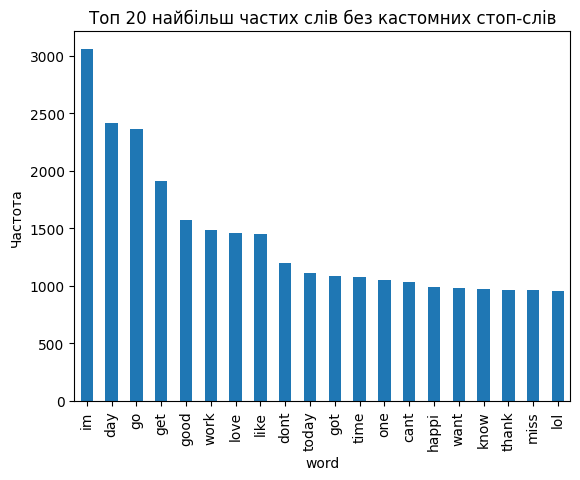

In [ ]:
# Частина 1: Стандартна очистка тексту та пошук кастомних стоп-слів

# Функція для попередньої обробки тексту
def preprocess_text(text):
    text = text.lower()  # Переведемо текст у нижній регістр
    text = re.sub(r'[^a-z\s]', '', text)  # Видаляємо все, що не є літерами або пробілами
    words = text.split()  # Розбиваємо текст на слова
    # Видаляємо стандартні стоп-слова та стемінг
    words = [stemmer.stem(word) for word in words if word not in english_stopwords]
    return ' '.join(words)

# Попередня обробка тексту
df.loc[:, 'clean_text'] = df['text'].apply(preprocess_text)

# Векторизація
vectorizer = CountVectorizer(max_features=1500)
X = vectorizer.fit_transform(df['clean_text'])

# Пошук частотності слів без кастомних стоп-слів
def analyze_word_frequency(X, vectorizer):
    # Отримуємо всі слова та їх частоти
    word_counts = X.toarray().sum(axis=0)
    words = vectorizer.get_feature_names_out()

    # Створюємо DataFrame для аналізу
    word_freq_df = pd.DataFrame({'word': words, 'count': word_counts}).sort_values(by='count', ascending=False)

    # Виводимо кілька найбільш частих слів
    print("Топ 20 найбільш частих слів без кастомних стоп-слів:")
    print(word_freq_df.head(20))

    # Візуалізація частотності слів
    plt.figure(figsize=(10, 6))
    word_freq_df.head(20).plot(kind='bar', x='word', y='count', legend=False)
    plt.title('Топ 20 найбільш частих слів без кастомних стоп-слів')
    plt.ylabel('Частота')
    plt.show()

# Виконання аналізу частотності
analyze_word_frequency(X, vectorizer)

Топ 20 найбільш частих слів з кастомними стоп-слів:
        word  count
336      day   2414
560     good   1569
1461    work   1483
797     love   1458
770     like   1454
1322   today   1115
566      got   1087
1317    time   1079
214     cant   1030
600    happi    993
1407    want    983
738     know    969
1294   thank    962
853     miss    961
1046  realli    909
102     back    897
1112     see    893
1302   think    875
477     feel    869
871   mother    788


<Figure size 1000x600 with 0 Axes>

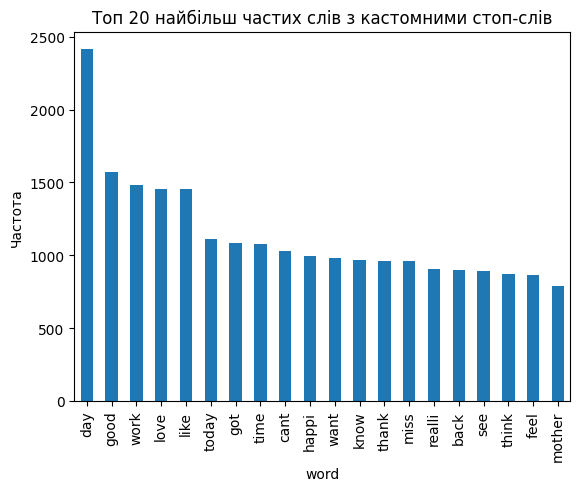

In [ ]:
# Мій персональний список кастомних стоп-слів
custom_stop_words = ['im', 'dont', 'lol', 'one', 'go', 'get']

# Оновлення векторизатора з кастомними стоп-словами
vectorizer_custom = CountVectorizer(max_features=1500, stop_words=custom_stop_words)
X_custom = vectorizer_custom.fit_transform(df['clean_text'])

# Пошук частотності слів з урахуванням кастомних стоп-слів
def analyze_word_frequency_custom(X_custom, vectorizer_custom):
    # Отримуємо всі слова та їх частоти
    word_counts = X_custom.toarray().sum(axis=0)
    words = vectorizer_custom.get_feature_names_out()

    # Створюємо DataFrame для аналізу
    word_freq_df_custom = pd.DataFrame({'word': words, 'count': word_counts}).sort_values(by='count', ascending=False)

    # Виводимо кілька найбільш частих слів з урахуванням кастомних стоп-слів
    print("Топ 20 найбільш частих слів з кастомними стоп-слів:")
    print(word_freq_df_custom.head(20))

    # Візуалізація частотності слів з кастомними стоп-слів
    plt.figure(figsize=(10, 6))
    word_freq_df_custom.head(20).plot(kind='bar', x='word', y='count', legend=False)
    plt.title('Топ 20 найбільш частих слів з кастомними стоп-слів')
    plt.ylabel('Частота')
    plt.show()

# Виконання аналізу частотності з кастомними стоп-слів
analyze_word_frequency_custom(X_custom, vectorizer_custom)

In [ ]:
# Для методу 3.2
print('Розмірність матриці векторизації (метод 3.2):', X_custom.shape)
print(X_custom.toarray()[:5])  # Перші 5 векторів

Розмірність матриці векторизації (метод 3.2): (27480, 1500)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# Конвертуємо матрицю в DataFrame
bow_df = pd.DataFrame(bow_features.toarray(), columns=vectorizer.get_feature_names_out())

# Додаємо до основного DataFrame
df_with_bow = pd.concat([df.reset_index(drop=True), bow_df], axis=1)

# Тепер df_with_bow міститиме оригінальний текст з додатковими стовпцями для кожного слова
df_with_bow


,textID,text,selected_text,sentiment,text_length,clean_text,abl,absolut,abt,ac,...,youd,youll,young,your,youtub,youv,yr,yum,yummi,yup
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,id respond go,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,sooo sad miss san diego,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,088c60f138,my boss is bullying me...,bullying me,negative,25,boss bulli,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,interview leav alon,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,75,son couldnt put releas alreadi bought,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27475,4eac33d1c0,wish we could come see u on Denver husband lost his job and can`t afford it,d lost,negative,77,wish could come see u denver husband lost job cant afford,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27476,4f4c4fc327,"I`ve wondered about rake to. The client has made it clear .NET only, don`t force devs to learn a new lang #agile #ccnet",", don`t force",negative,122,ive wonder rake client made clear net dont forc dev learn new lang agil ccnet,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27477,f67aae2310,Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend Take care hun xxxx,Yay good for both of you.,positive,111,yay good enjoy break probabl need hectic weekend take care hun xxxx,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27478,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,27,worth,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Побудова класифікатора


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Векторизація текстів
vectorizer = CountVectorizer(max_features=1500, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])
y = df['sentiment']

# Створення списку індексів
indices = np.arange(X.shape[0])

# Розділення індексів на навчальні та тестові
X_train_idx, X_test_idx = train_test_split(indices, test_size=0.3, random_state=42, stratify=y)

# Формування навчальних та тестових наборів
X_train_bow = X[X_train_idx]
X_test_bow = X[X_test_idx]
y_train = y.iloc[X_train_idx]
y_test = y.iloc[X_test_idx]

# Навчання моделей
# Логістична регресія
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_bow, y_train)
lr_predictions = lr_model.predict(X_test_bow)

# Дерево рішень
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_bow, y_train)
dt_predictions = dt_model.predict(X_test_bow)

# Оцінка якості класифікації
def evaluate_model(predictions, y_true):
    print(f"Accuracy: {accuracy_score(y_true, predictions)}")
    print("Classification Report:")
    print(classification_report(y_true, predictions))

print("Logistic Regression:")
evaluate_model(lr_predictions, y_test)

print("Decision Tree:")
evaluate_model(dt_predictions, y_test)


Logistic Regression:
Accuracy: 0.6871664240659874
Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.60      0.65      2334
     neutral       0.63      0.73      0.68      3335
    positive       0.77      0.70      0.73      2575

    accuracy                           0.69      8244
   macro avg       0.70      0.68      0.69      8244
weighted avg       0.69      0.69      0.69      8244

Decision Tree:
Accuracy: 0.6256671518680252
Classification Report:
              precision    recall  f1-score   support

    negative       0.60      0.60      0.60      2334
     neutral       0.61      0.60      0.60      3335
    positive       0.68      0.69      0.68      2575

    accuracy                           0.63      8244
   macro avg       0.63      0.63      0.63      8244
weighted avg       0.63      0.63      0.63      8244



In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Створюємо LabelEncoder для y_train та y_test
label_encoder = LabelEncoder()

# Закодуємо y_train та y_test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Виведемо відповідність між текстовими і числовими категоріями
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Відповідність між текстовими та числовими категоріями:", class_mapping)

# Тренування XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_bow, y_train_encoded)

# Прогнозування на тестових даних
y_pred_xgb = xgb.predict(X_test_bow)

# Оцінка XGBoost
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred))

print("XGBoost:")
evaluate_model(y_test_encoded, y_pred_xgb, "XGBoost")


Відповідність між текстовими та числовими категоріями: {'negative': 0, 'neutral': 1, 'positive': 2}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[07:14:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBoost:
XGBoost Accuracy: 0.6895924308588064
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.54      0.63      2334
           1       0.62      0.79      0.69      3335
           2       0.77      0.70      0.73      2575

    accuracy                           0.69      8244
   macro avg       0.72      0.68      0.69      8244
weighted avg       0.71      0.69      0.69      8244



XGBoost є найкращою моделлю за загальною точністю (Accuracy) та в усіх важливих метриках для класів Neutral та Positive. Логістична регресія, з іншого боку, має найкращі показники для класу Negative.

XGBoost має найвищу точність та краще справляється з більшістю класів, тому її можна вважати найкращою моделлю з цих трьох.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# Визначення гіперпараметрів для випадкового пошуку
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': randint(3, 10),  # Випадкове значення від 3 до 9
    'learning_rate': uniform(0.01, 0.1),  # Випадкове значення від 0.01 до 0.1
    'subsample': uniform(0.8, 0.2),  # Випадкове значення від 0.8 до 1.0
    'colsample_bytree': uniform(0.8, 0.2)  # Випадкове значення від 0.8 до 1.0
}

# Створення моделі XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Налаштування RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist,
                                   n_iter=50, scoring='accuracy',
                                   cv=3, verbose=1, n_jobs=-1, random_state=42)

# Пошук кращих гіперпараметрів
random_search.fit(X_train_bow, y_train_encoded)

# Виведення кращих гіперпараметрів та точності
print("Кращі гіперпараметри:", random_search.best_params_)
print("Найкраща точність:", random_search.best_score_)

# Використання кращих гіперпараметрів для фінальної моделі
best_xgb_model = random_search.best_estimator_

# Прогнозування на тестових даних з кращою моделлю
y_pred_best_xgb = best_xgb_model.predict(X_test_bow)

# Оцінка фінальної моделі
print("Оцінка кращої моделі XGBoost:")
evaluate_model(y_test_encoded, y_pred_best_xgb, "XGBoost (Best Model)")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[07:37:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Кращі гіперпараметри: {'colsample_bytree': 0.8186205535611799, 'learning_rate': 0.09972157579533268, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8377414216682759}
Найкраща точність: 0.6947390309835724
Оцінка кращої моделі XGBoost:
XGBoost (Best Model) Accuracy: 0.6935953420669578
XGBoost (Best Model) Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.56      0.64      2334
           1       0.62      0.78      0.69      3335
           2       0.77      0.71      0.74      2575

    accuracy                           0.69      8244
   macro avg       0.72      0.68      0.69      8244
weighted avg       0.71      0.69      0.69      8244



Модель дещо покращила результат, але не суттєво. Варто спробувати пошук в більшому діапазоні.

# Аналіз впливовості слів з отриманого класифікатора


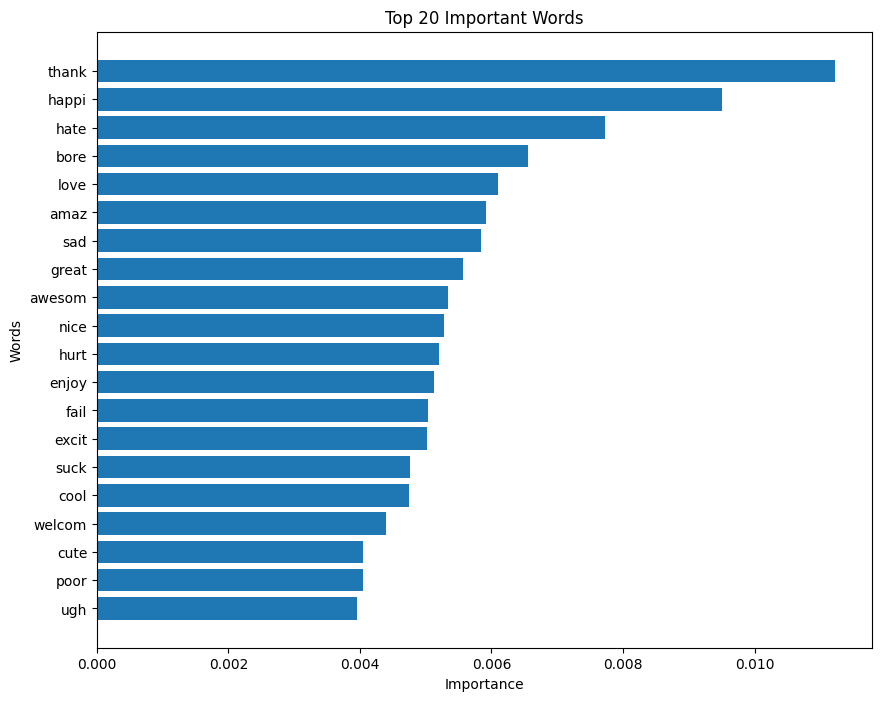

In [ ]:
# Отримання важливостей ознак з кращої моделі
importances = random_search.best_estimator_.feature_importances_

# Отримання слів з CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Створення DataFrame для важливостей
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Сортування за важливістю
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Візуалізація важливих слів
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20))
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Top 20 Important Words')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
importance_df.head(20)

,Feature,Importance
1301,thank,0.011223
593,happi,0.009504
596,hate,0.007721
165,bore,0.006561
796,love,0.006093
47,amaz,0.005915
1091,sad,0.005843
566,great,0.005573
94,awesom,0.005331
898,nice,0.005281


Загалом все виглядає логічно.

Позитивні Слова: Переважають у списку і, як очікується, мають високу важливість для позитивного сентименту. Вони використовуються для вираження позитивних емоцій і ставлення.

Негативні Слова: Також присутні у списку і мають високу важливість для негативного сентименту. Це логічно, оскільки ці слова безпосередньо виражають негативні емоції.

Неоднозначні Слова: Можуть мати як позитивний, так і негативний контекст в залежності від контексту їх використання.

# Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ініціалізація TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Векторизація текстів
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

# Отримання всіх слів та їх TF-IDF значень
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_tfidf.mean(axis=0).A1

# Створюємо DataFrame для аналізу
tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf_score': tfidf_scores}).sort_values(by='tfidf_score', ascending=False)

# Виведемо кілька найбільш впливових слів
print(tfidf_df.head())


     word  tfidf_score
438    im     0.029721
219   day     0.025747
969  work     0.019105
361  good     0.019048
523  love     0.018313


In [ ]:
# Перекодування міток
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Підготовка TF-IDF матриць для навчальних і тестових даних
from sklearn.feature_extraction.text import TfidfVectorizer

# Створення TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(max_features=1500, stop_words='english')

# Підготовка TF-IDF матриць для навчальних і тестових даних
X_train_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'].iloc[X_train_idx])  # Використовуйте текстові дані
X_test_tfidf = tfidf_vectorizer.transform(df['clean_text'].iloc[X_test_idx])  # Використовуйте текстові дані

# Перевірка розмірів даних
print("Розмір X_train_tfidf:", X_train_tfidf.shape)
print("Розмір y_train_encoded:", y_train_encoded.shape)
print("Розмір X_test_tfidf:", X_test_tfidf.shape)
print("Розмір y_test_encoded:", y_test_encoded.shape)

# Створення класифікатора
xgb_tfidf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Тренування класифікатора
xgb_tfidf.fit(X_train_tfidf, y_train_encoded)

# Прогнозування на тестових даних
y_pred_xgb_tfidf = xgb_tfidf.predict(X_test_tfidf)

# Оцінка XGBoost з TF-IDF
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred))

print("XGBoost (TF-IDF):")
evaluate_model(y_test_encoded, y_pred_xgb_tfidf, "XGBoost (TF-IDF)")

Розмір X_train_tfidf: (19236, 1500)
Розмір y_train_encoded: (19236,)
Розмір X_test_tfidf: (8244, 1500)
Розмір y_test_encoded: (8244,)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[07:53:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBoost (TF-IDF):
XGBoost (TF-IDF) Accuracy: 0.6855895196506551
XGBoost (TF-IDF) Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.53      0.63      2334
           1       0.61      0.79      0.69      3335
           2       0.77      0.68      0.72      2575

    accuracy                           0.69      8244
   macro avg       0.72      0.67      0.68      8244
weighted avg       0.70      0.69      0.68      8244



В результаті аналізу можна стверджувати, що XGBoost (Best Model) продемонструвала найвищу точність, проте різниця між трьома моделями є незначною. Це вказує на те, що ефективність моделей може залежати від параметрів моделювання, методів векторизації та попередньої обробки даних.

Особливо варто зазначити, що XGBoost (TF-IDF) показала нижчу точність в порівнянні з XGBoost, хоча обидві моделі були побудовані на однакових даних. Це підкреслює важливість правильного вибору методів векторизації та попередньої обробки, оскільки деталі можуть істотно вплинути на результати класифікації.

Рекомендується продовжити дослідження впливу різних стратегій попередньої обробки та векторизації для досягнення кращих результатів у класифікації текстів.


# Аналіз помилок класифікації з векторизацією TF-IDF.


In [ ]:
# Знаходження помилкових прогнозів
incorrect_predictions = X_test_tfidf[y_pred_xgb_tfidf != y_test_encoded]
incorrect_labels = y_test_encoded[y_pred_xgb_tfidf != y_test_encoded]

# Створення DataFrame з помилковими прогнозами
error_analysis_df = pd.DataFrame({
    'Text': incorrect_predictions,
    'True Label': incorrect_labels,
    'Predicted Label': y_pred_xgb_tfidf[y_pred_xgb_tfidf != y_test_encoded]
})

# Виведення кількох прикладів
error_analysis_df.head(20)

,Text,True Label,Predicted Label
0,"(0, 796)\t0.5362559395268345\n (0, 1419)\t0.43767551701861124\n (0, 1484)\t0.7217130379345265",0,1
1,"(0, 46)\t0.3214660987806808\n (0, 773)\t0.22630443671190367\n (0, 835)\t0.33497805446443174\n (0, 953)\t0.3422530121206101\n (0, 1190)\t0.38059577998431027\n (0, 1367)\t0.4547687784744414\n (0, 1449)\t0.2738513832138487\n (0, 1495)\t0.4352425281101237",0,2
2,"(0, 390)\t0.27173199131429115\n (0, 468)\t0.42397761323016286\n (0, 479)\t0.29520626117961146\n (0, 648)\t0.29810365336771805\n (0, 773)\t0.261891619879245\n (0, 1091)\t0.5548084663455285\n (0, 1190)\t0.44044582946549365",2,0
3,"(0, 32)\t0.551500457885653\n (0, 384)\t0.551500457885653\n (0, 1046)\t0.39414596465002344\n (0, 1319)\t0.29019470981031753\n (0, 1406)\t0.3900390734939749",0,1
4,"(0, 771)\t0.4232385616758097\n (0, 816)\t0.33958150812855953\n (0, 855)\t0.6209549506825149\n (0, 874)\t0.3451052016917865\n (0, 1456)\t0.448186198176463",0,2
5,"(0, 556)\t1.0",0,2
6,"(0, 173)\t0.4865512472560015\n (0, 251)\t0.5264942217593563\n (0, 610)\t0.3869767028597678\n (0, 1253)\t0.5799316767442713",2,1
7,"(0, 594)\t0.482809879136603\n (0, 655)\t0.41372220940959853\n (0, 1235)\t0.6411981659664225\n (0, 1457)\t0.4296434172783696",0,1
8,"(0, 206)\t0.44688040128998296\n (0, 702)\t0.44688040128998296\n (0, 776)\t0.4014781441812291\n (0, 835)\t0.3122432926280446\n (0, 889)\t0.38731891077295016\n (0, 1348)\t0.43806312467161224",0,1
9,"(0, 670)\t0.38616552507243945\n (0, 711)\t0.5730729035854962\n (0, 794)\t0.223102518153073\n (0, 796)\t0.4029128437528826\n (0, 897)\t0.22188042430908114\n (0, 1178)\t0.3621729799527483\n (0, 1340)\t0.36048571546582414",0,1


In [ ]:
# Виведення кількості рядків з помилкою
print(f'Кількість рядків з помилкою: {num_errors}')

Кількість рядків з помилкою: 2592


In [ ]:
# Відповідність між текстовими та числовими категоріями
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Аналіз помилок
error_indices = y_pred_xgb_tfidf != y_test_encoded

# Перевіряємо довжину масивів
num_errors = error_indices.sum()  # Кількість помилок

# Використовуємо наш масив текстів
error_analysis_df = pd.DataFrame({
    'Text': [df['text'].iloc[i] for i in range(len(y_test_encoded)) if error_indices[i]],  # Оригінальні тексти
    'Text_clean': [df['clean_text'].iloc[i] for i in range(len(y_test_encoded)) if error_indices[i]],  # Очищені тексти
    'True Label': y_test_encoded[error_indices],
    'Predicted Label': y_pred_xgb_tfidf[error_indices]
})

# Додаємо стовпці з розшифруванням
error_analysis_df['True Label (Text)'] = error_analysis_df['True Label'].map(label_mapping)
error_analysis_df['Predicted Label (Text)'] = error_analysis_df['Predicted Label'].map(label_mapping)

# Виведення перших 50 помилок
error_analysis_df.head(50)


,Text,Text_clean,True Label,Predicted Label,True Label (Text),Predicted Label (Text)
0,my boss is bullying me...,boss bulli,0,1,negative,neutral
1,My Sharpie is running DANGERously low on ink,sharpi run danger low ink,0,2,negative,positive
2,test test from the LG enV2,test test lg env,2,0,positive,negative
3,"Uh oh, I am sunburned",uh oh sunburn,0,1,negative,neutral
4,"S`ok, trying to plot alternatives as we speak *sigh*",sok tri plot altern speak sigh,0,2,negative,positive
5,is back home now gonna miss every one,back home gonna miss everi one,0,2,negative,positive
6,Hes just not that into you,hes,2,1,positive,neutral
7,gotta restart my computer .. I thought Win7 was supposed to put an end to the constant rebootiness,gotta restart comput thought win suppos put end constant rebooti,0,1,negative,neutral
8,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cALLed LoSe f0LloWeRs FridAy... smH,see wat mean bout follw friiday call lose fllower friday smh,0,1,negative,neutral
9,I`m sorry.,im sorri,0,1,negative,neutral


Аналіз помилок класифікації може вказувати на кілька причин, чому класифікатор допустив помилки:

Сарказм та іронія: Багато текстів можуть містити сарказм або іронію, що ускладнює їхню класифікацію.

Неправильне використання емоційних слів: Деякі слова можуть мати різні значення залежно від контексту.

Неповні або нечіткі вирази: Деякі тексти можуть бути занадто короткими або не містити достатньо інформації, щоб класифікатор зміг правильно визначити емоцію.

Пропозиції для покращення якості класифікації
Покращення препроцесингу тексту:

Додати більш детальну очистку тексту, наприклад, додати більше слів у перелік стоп-слів. Можливо, свпробувати прибрати з набору даних емоційні слова, так як з аналізу помилок видно, що вони впливають на неправильну класифікацію. Прибрати занадто короткі речення. Видалити знаки, типу знак питання, знак оклику і тд.

Провести налаштування гіперпараметрів моделей. Можливо, варто спробувати різні значення learning_rate, depth дерев, subsample та інші параметри для покращення ефективності моделі. Спробувати комбінувати кілька моделей (наприклад, XGBoost з Logistic Regression або Decision Trees) для досягнення кращих результатів, використовуючи методи ансамблювання, такі як VotingClassifier або StackingClassifier.

Покращення векторизації: Використання більш складних методів векторизації, таких як Word2Vec або BERT, може допомогти моделі краще зрозуміти контекст і семантику слів. Включення додаткових функцій для аналізу тональності, таких як виявлення емоцій або аналіз настрою, може підвищити точність класифікації.